In [ ]:
import os
import numpy as np
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _composite_add_max(rgb, gray_u8, color_rgb):
    f = (gray_u8.astype(np.float32) / 255.0)[..., None]
    color = np.array(color_rgb, dtype=np.float32)[None, None, :]
    layer = (f * color).astype(np.uint8)
    return np.maximum(rgb, layer)

def _clip_and_norm(arr, perc=(1, 99)):
    """Clip intensities by percentiles and normalize to 0–1."""
    lo, hi = np.percentile(arr, perc)
    arr_clipped = np.clip(arr, lo, hi)
    if hi > lo:
        arr_norm = (arr_clipped - lo) / (hi - lo)
    else:
        arr_norm = np.zeros_like(arr)
    return arr_norm

def save_rgb_slices_from_nii(
    nii_path: str,
    out_dir: str,
    channels=(0,),
    colors=((0, 0, 255),),
    norm: str = "volume",          # "slice" or "volume"
    perc: tuple = (1, 99),         # percentile clip for normalization
    downscale: int = 2,
    file_prefix: str = None,
    z=None,
    show: bool = False,
    quality: int = 100
):
    """
    Save selected slice(s) from a NIfTI file as high-quality JPGs with percentile clipping.

    norm:  "volume" = global normalization
           "slice"  = per-slice normalization
    perc:  (low, high) percentiles for clipping (e.g., (1,99))
    """
    assert len(channels) == len(colors), "channels and colors must match"
    _ensure_dir(out_dir)

    img = sitk.ReadImage(nii_path)
    arr = sitk.GetArrayFromImage(img)
    n_comp = img.GetNumberOfComponentsPerPixel()

    # --- Normalize to (C,Z,Y,X)
    if n_comp > 1:
        Z, Y, X, C = arr.shape
        data = np.moveaxis(arr, -1, 0)
    else:
        if arr.ndim == 3:
            data = arr[np.newaxis, ...]
        elif arr.ndim == 4:
            data = arr
        else:
            raise ValueError(f"Unsupported NIfTI shape {arr.shape}")

    C, Z, Y, X = data.shape

    if norm == "volume":
        data = _clip_and_norm(data, perc=perc)

    if z is None:
        z_indices = range(Z)
    elif isinstance(z, int):
        z_indices = [z if z >= 0 else Z + z]
    else:
        z_indices = [zi if zi >= 0 else Z + zi for zi in z]

    base = file_prefix or os.path.splitext(os.path.basename(nii_path))[0]
    if base.endswith(".nii"):
        base = base[:-4]

    for zi in z_indices:
        rgb = np.zeros((Y, X, 3), dtype=np.uint8)
        for c, color in zip(channels, colors):
            gray = data[c, zi]
            if norm == "slice":
                gray = _clip_and_norm(gray, perc=perc)
            gray_u8 = (gray * 255).clip(0, 255).astype(np.uint8)
            rgb = _composite_add_max(rgb, gray_u8, color)

        if downscale > 1:
            h, w = rgb.shape[:2]
            rgb = cv2.resize(rgb, (w // downscale, h // downscale), interpolation=cv2.INTER_CUBIC)

        out_name = f"{base}_z{zi:04d}.jpg"
        out_path = os.path.join(out_dir, out_name)
        cv2.imwrite(out_path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
                    [cv2.IMWRITE_JPEG_QUALITY, quality,
                     cv2.IMWRITE_JPEG_PROGRESSIVE, 1])

        if show:
            plt.figure(figsize=(8, 8))
            plt.imshow(rgb)
            plt.title(f"Slice {zi} / {Z-1} (perc={perc})")
            plt.axis("off")
            plt.show()

    print(f"[DONE] Saved {len(z_indices)} slice(s) to {out_dir} (norm={norm}, perc={perc}, quality={quality}).")





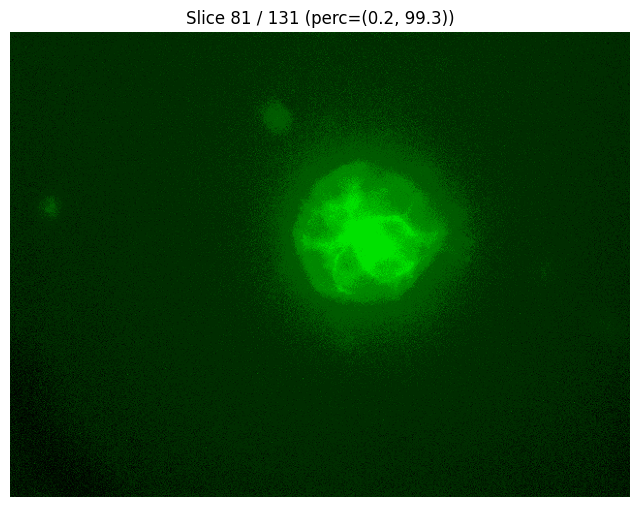

[DONE] Saved 1 slice(s) to images_out (norm=volume, perc=(0.2, 99.3), quality=100).


In [ ]:


save_rgb_slices_from_nii(
    r"/Users/muhammadsohaib/Downloads/low_evos/mcf7_s.nii.gz",
    out_dir="images_out",
    channels=(0,),
    colors=((0,225,0),),    # or multi-channel colors
    z=81,
    norm="volume",
    perc=(0.2, 99.8),
    downscale=2,
    quality=100,
    show=True
)


In [ ]:
####


import os
import numpy as np
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt

def _composite_add_max(rgb, gray_u8, color_rgb):
    f = (gray_u8.astype(np.float32) / 255.0)[..., None]
    color = np.array(color_rgb, dtype=np.float32)[None, None, :]
    layer = (f * color).astype(np.uint8)
    return np.maximum(rgb, layer)

def _clip_and_norm(arr, perc=(1, 99)):
    """Clip by percentiles and normalize to [0,1]. Accepts any shape."""
    lo, hi = np.percentile(arr, perc)
    arr_clipped = np.clip(arr, lo, hi)
    if hi > lo:
        return (arr_clipped - lo) / (hi - lo)
    return np.zeros_like(arr_clipped, dtype=np.float32)
    
def _ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def _resample_to_reference(moving_img: sitk.Image, reference_img: sitk.Image, interp="linear") -> sitk.Image:
    rf = sitk.ResampleImageFilter()
    rf.SetReferenceImage(reference_img)
    rf.SetInterpolator(sitk.sitkLinear if interp == "linear" else sitk.sitkNearestNeighbor)
    return rf.Execute(moving_img)

def _as_CZYX(arr: np.ndarray, n_comp: int) -> np.ndarray:
    """
    Return array as (C,Z,Y,X).
    Supports:
      - 3D scalar -> (1,Z,Y,X)
      - 4D scalar -> (C,Z,Y,X) (already)
      - 4D vector (Z,Y,X,Cv) -> moveaxis to (Cv,Z,Y,X)
    """
    if n_comp > 1:
        if arr.ndim != 4:
            raise ValueError(f"Unexpected vector image shape {arr.shape}")
        Z, Y, X, Cv = arr.shape
        return np.moveaxis(arr, -1, 0)  # (Cv,Z,Y,X)
    else:
        if arr.ndim == 3:
            return arr[np.newaxis, ...]  # (1,Z,Y,X)
        elif arr.ndim == 4:
            return arr  # already (C,Z,Y,X)
        else:
            raise ValueError(f"Unsupported image shape {arr.shape}")

def overlay_two_niftis_slice(
    nii_path_a: str,
    nii_path_b: str,
    out_dir: str = "images_out",
    color_a=(0, 0, 255),        # blue
    color_b=(255, 0, 0),        # red
    chan_a: int = 0,            # which channel to use (if 4D)
    chan_b: int = 0,
    z: int = 33,
    norm: str = "volume",       # "volume" or "slice"
    perc=(1, 99),               # percentile clipping
    downscale: int = 2,
    resample_b_to_a: bool = True,
    quality: int = 100,
    show: bool = True,
    file_prefix: str = None
):
    """
    Overlay one slice (z) from two volumes with different colors and save a JPG.
    If grids differ, resamples volume B to match volume A (toggle via resample_b_to_a).
    """
    _ensure_dir(out_dir)

    img_a = sitk.ReadImage(nii_path_a)
    img_b = sitk.ReadImage(nii_path_b)

    if resample_b_to_a:
        img_b = _resample_to_reference(img_b, img_a, interp="linear")

    arr_a = sitk.GetArrayFromImage(img_a)  # (Z,Y,X) or (Z,Y,X,Cv)
    arr_b = sitk.GetArrayFromImage(img_b)

    data_a = _as_CZYX(arr_a, img_a.GetNumberOfComponentsPerPixel())
    data_b = _as_CZYX(arr_b, img_b.GetNumberOfComponentsPerPixel())

    _, Za, Ya, Xa = data_a.shape
    _, Zb, Yb, Xb = data_b.shape
    if (Za, Ya, Xa) != (Zb, Yb, Xb):
        raise ValueError(
            f"Volumes are on different grids after resampling setting. "
            f"A: {(Za,Ya,Xa)} vs B: {(Zb,Yb,Xb)}. "
            f"Try resample_b_to_a=True or inspect your inputs."
        )

    z = max(0, min(z, Za - 1))

    if norm == "volume":
        data_a = _clip_and_norm(data_a, perc=perc)
        data_b = _clip_and_norm(data_b, perc=perc)

    Y, X = Ya, Xa
    rgb = np.zeros((Y, X, 3), dtype=np.uint8)

    gray_a = data_a[chan_a, z, ...]
    if norm == "slice":
        gray_a = _clip_and_norm(gray_a, perc=perc)
    a_u8 = (gray_a * 255).clip(0, 255).astype(np.uint8)
    rgb = _composite_add_max(rgb, a_u8, color_a)

    gray_b = data_b[chan_b, z, ...]
    if norm == "slice":
        gray_b = _clip_and_norm(gray_b, perc=perc)
    b_u8 = (gray_b * 255).clip(0, 255).astype(np.uint8)
    rgb = _composite_add_max(rgb, b_u8, color_b)

    if downscale and downscale > 1:
        h, w = rgb.shape[:2]
        rgb = cv2.resize(rgb, (w // downscale, h // downscale), interpolation=cv2.INTER_CUBIC)

    base_a = os.path.splitext(os.path.basename(nii_path_a))[0]
    base_b = os.path.splitext(os.path.basename(nii_path_b))[0]
    if base_a.endswith(".nii"): base_a = base_a[:-4]
    if base_b.endswith(".nii"): base_b = base_b[:-4]

    base = file_prefix or f"{base_a}__OVER__{base_b}"
    out_name = f"{base}_z{z:04d}.jpg"
    out_path = os.path.join(out_dir, out_name)

    cv2.imwrite(
        out_path,
        cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR),
        [cv2.IMWRITE_JPEG_QUALITY, quality, cv2.IMWRITE_JPEG_PROGRESSIVE, 1]
    )

    if show:
        plt.figure(figsize=(8, 8))
        plt.imshow(rgb)
        plt.title(f"Overlay z={z}  A→{color_a}, B→{color_b}  (perc={perc}, norm={norm})")
        plt.axis("off")
        plt.show()

    print(f"[DONE] Saved overlay: {out_path}")
    return out_path



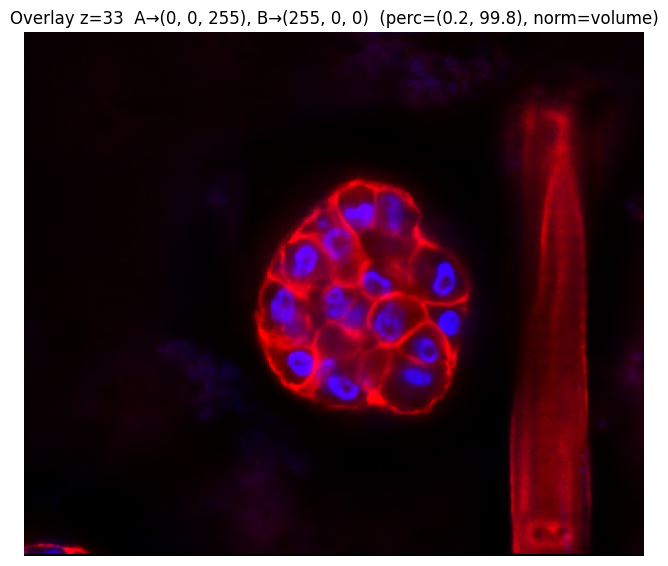

[DONE] Saved overlay: images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.jpg


'images_out/AT1_no_apotome_07_raw_pred_f__OVER__AT1_no_apotome_07_raw_pred_sec_z0033.jpg'

In [5]:
overlay_two_niftis_slice(
    nii_path_a=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_f.nii.gz",
    nii_path_b=r"/Users/muhammadsohaib/Downloads/AT1_no_apotome_07_raw_pred_sec.nii.gz",
    color_a=(0, 0, 255),        # first file → blue
    color_b=(255, 0, 0),        # second file → red
    z=33,
    norm="volume",              # or "slice" if you need per-slice equalization
    perc=(0.2, 99.8),           # matches what you were using
    downscale=2,
    resample_b_to_a=True,       # keep True unless you already know grids match
    quality=100,
    show=True
)
## SAME 